# CS 345 Project
#### _Ben Spencer and Matteo Selvaggio_

### **Part 0: Introduction, Importing Data, and Libraries**

##### **Topic Introduction**
The topic we selected to explore is classical game theory. Machine learning and AI has a strong history with classical games such as Go and Chess since most classical games have a finite number of continuous moves and can technically be "solved" if given enough time and game knowledge. There have been many examples of expectional AI models that have been used to play and study various games, including AlphaGo for Go and Stockfish for chess.

To explore this topic, we wanted to find out if a model could be trained simply to determine what the next best move should be in the game of chess. Typically, most models that determine the next best move utilize a variety of different parameters in combination with chess theory to come up with accurate predictions. Our initial goal, however, would be to train a model with only game board data and find out how accurately it could predict what the next best move might be.

##### **Data Description**
The dataset being used is a dataset from the popular chess website Lichess. The data itself contains a variety of features related to over 3,000,000 chess puzzles that are available to play online. The list of available features are as follows:

* *PuzzleId* (The ID number corresponding to the puzzle)
* *FEN* (An encoding of the board state at the start of the puzzle)
* *Moves* (A list of moves required to solve the puzzle)
* *Rating* (Chess ELO rating level of the puzzle) 
* *RatingDeviation* (The deviation in ELO rating between the two players in the puzzle)
* *Popularity* (Average upvotes and downvotes of the puzzle) 
* *NbPlays* (Number of times the puzzle has been played on Lichess)
* *Themes* (A list of tags that describe the characteristics of the game in the puzzle)
* *GameUrl* (Link to the Lichess website for the puzzle)
* *OpeningTags* (If the puzzle is withing the first 20 moves of the game, describes the opening of the current game)

In the case of the model we are trying to train, we had decided to rule out using most of the data columns with the exception of the FEN and Moves columns. From the FEN data, we are able to obtain a value for the current board state which will be used as the X input vector for the model. Conversely, the Moves list will contain the next best move required to solve the puzzle, which will be used as our output or label vector.

Finally, since the data contains over 3,000,000 data points, training the model on the entire dataset would be very computational intense. Therefore, we shortened the datasets overall size to the first 30,000 entries to make running and training each model faster.

In [8]:
# installing zstandard package to unpack .zst compressed files
# %pip install zstandard
import zstandard as zstd

# installing chess package which contains useful methods for processing chess boards.
# pip install chess
import chess

# importing numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# importing sklearn methods
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# importing keras with GPU
# If using Anaconda, use the following commands in a local conda terminal:
# %pip install --upgrade pip
# %conda create -n tf tensorflow
# %conda activate tf
# %pip install tensorflow[and-cuda]
import tensorflow as tf

# import data
# the usecols parameter extracts the PuzzleID, FEN, and Game Moves columns only
# the skiprows parameter only receives the last 10,000 entries
fen_data = np.loadtxt("lichess_db_puzzle.csv", delimiter=',', dtype=str, skiprows=3802157, usecols=(1))
move_list = np.loadtxt("lichess_db_puzzle.csv", delimiter=',', dtype=str, skiprows=3802157, usecols=(2))
print(f'Shape of the features array (X): {fen_data.shape}')
print(f'Head of the features array: {fen_data[:5]}\n')
print(f'Shape of the labels array (Y): {move_list.shape}')
print(f'Head of the labels array: {move_list[:10]}')


Shape of the features array (X): (30000,)
Head of the features array: ['5rk1/2q3pp/4p3/1P1pn3/8/2pp2N1/4QPPP/2B1R1K1 w - - 0 26'
 '6k1/np4qp/4p3/1p1pNp1Q/1P1P4/P3P1B1/5KPP/2r5 b - - 1 31'
 'rn2k1r1/pp2qp2/4bn2/8/7Q/2N1P3/PPP1B2P/R3K1NR w KQq - 1 15'
 '6k1/5pp1/b1Np3p/2qPp3/Pp2P1QP/8/5PPK/8 b - - 3 32'
 'r2q1rk1/p3pp1p/2np1npQ/2p5/1p2P3/3P1B1P/PPP1NPP1/R4RK1 b - - 1 13']

Shape of the labels array (Y): (30000,)
Head of the labels array: ['e2e5 c7e5 e1e5 d3d2 c1d2 c3d2' 'a7c6 h5e8 g7f8 e8e6'
 'c3e4 e7b4 c2c3 b4e4 h4e4 f6e4' 'b4b3 c6e7 g8f8 g4d7'
 'c6d4 e2d4 c5d4 e4e5 d6e5 f3a8' 'd8g8 e4f6 h7h8 g3g8'
 'e6e7 c3d5 e7f7 d5f6 f7f6 f5f6' 'h5g4 d6e5' 'f6h7 e4e5 f7f5 e5f6'
 'f3g5 g3h2 g1h1 h5g3 h1h2 g3e2 h2h1 e2g3']


#### **Part 1: Organizing the Data**

In [9]:
'''
Contains some example code that will be helpful for organizing data.

board_matrix = []

for i in range(10000):
    board_matrix.append(str(chess.Board(fen_data[i,1])))

label = []

for i in range(10000):
    label.append(move_list[i][2:4])

print(label[:5])
'''
data_size = len(move_list)
board_size = 64

def convert_board_to_str(fen):
    rtn = str(chess.Board(fen))
    return rtn

'''
The following function converts characters in the board position to vectors of size 12 to indicate what kind of
piece is in that space. Here is the template:

No piece:               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Black Pawn (p):         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Black Knight (n):       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Black Bishop (b):       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Black Rook (r):         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Black Queen (q):        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Black King (k):         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

White Pawn (P):         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
White Knight (N):       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
White Bishop (B):       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
White Rook (R):         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
White Queen (Q):        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
White King (K):         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
'''
def convert_str_to_vector(board_data):
    rtn = []

    for i in range(len(board_data)):
        x = board_data[i]

        if x == ' ' or x == '\n':
            continue
        elif x == '.':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'p':
            rtn.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'n':
            rtn.append([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'b':
            rtn.append([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'r':
            rtn.append([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'q':
            rtn.append([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'k':
            rtn.append([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
        elif x == 'P':
            rtn.append([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
        elif x == 'N':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
        elif x == 'B':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
        elif x == 'R':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
        elif x == 'Q':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
        elif x == 'K':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
        else:
            # For debugging
            print(f'ERROR: Board Contains Unnaccepted Character: {board_data[i]}')
            break

    return rtn

'''
The following functions will convert the position of a piece in chess (i.e., a4) to a 
numerical value to be used by a classifier.

A rank is considered a horizontal row and a file is a vertical column. Values for each
square are numbered in order from left to right, top to bottom, numbered 0-63.

For example, the space a1 would be assigned the value '0' and the space h8 would be 
assigned the value '63'.
'''
def rank(char):
    if char == 'a':
        return 0
    elif char == 'b':
        return 8
    elif char == 'c':
        return 16
    elif char == 'd':
        return 24
    elif char == 'e':
        return 32
    elif char == 'f':
        return 40
    elif char == 'g':
        return 48
    elif char == 'h':
        return 56
    else:
        raise Exception(f'ERROR: Unsupported rank character: {char}')
    
def file(char):
    if int(char) > 0 and int(char) <= 8:
        return (int(char) - 1)
    else:
        raise Exception(f'ERROR: Unsupported file character: {char}')

def convert_pos_to_val(pos):
    val = 0

    val += rank(pos[0])
    val += file(pos[1])
    return val


In [10]:
# Converting FEN data to serialized vector data
X_list = []
board_pos = np.arange(board_size)

for i in range(data_size):
    board_data = convert_board_to_str(fen_data[i])
    board_pos = convert_str_to_vector(board_data)
    X_list.append(board_pos)

X = np.array(X_list)
X.shape

# Converting move list to two label vectors for each model
labels = []

for i in range(data_size):
    val = convert_pos_to_val(move_list[i][:2])
    labels.append(val)

y_move_from = np.array(labels)

labels = []

for i in range(data_size):
    val = convert_pos_to_val(move_list[i][2:4])
    labels.append(val)

y_move_to = np.array(labels)

### Part 2 : Base Models

In [11]:
#Reshaping Data for Base Models
X_reshaped = X.reshape(X.shape[0], -1)
X_reshaped.shape

(30000, 768)

#### Random Forest

In [12]:
#Running a stratified k-fold cross validation on random forest classifier model
classifier = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracy = cross_val_score(classifier, X_reshaped, y_move_from, cv=cv, scoring='accuracy') 

In [13]:
print("Mean score:", np.mean(accuracy))
print("Standard deviation of scores:", np.std(accuracy))

Mean score: 0.15793333333333334
Standard deviation of scores: 0.0034522134606333036


#### SVM

In [43]:
#Benchmarking for optimal c values and optimal kernel for soft margin SVM.
c_values = [0.01, 0.1, 1, 10, 100, 1000]
kernels = ["poly", "rbf", "sigmoid"]
accuracies = []

for ker in kernels : 
    for c_value in c_values :
        classifier_set = svm.SVC(kernel = ker, C = c_value)
        accuracy_svm = cross_val_score(classifier_set, X_reshaped, y_move_from, cv=cv, scoring='accuracy') 
        accuracies.append(accuracy_svm)

In [73]:
accuracies_mean = []
for i in range(0, 18) :
    accuracies_mean.append(np.mean(accuracies[i]))

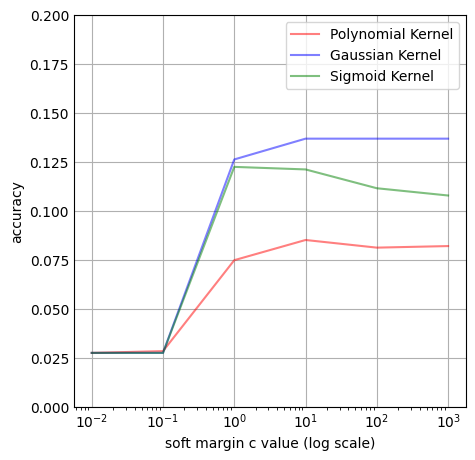

In [76]:
#Plotting mean accuracies of SVM cross validations.
accuracies_poly = accuracies_mean[:6]
accuracies_rbf = accuracies_mean[6:12]
accuracies_sigmoid = accuracies_mean[12:]

plt.figure(figsize=(4,4))
plt.semilogx(c_values, accuracies_poly, alpha=0.5, color='red', label = 'Polynomial Kernel')
plt.semilogx(c_values, accuracies_rbf, alpha=0.5, color='blue', label = 'Gaussian Kernel')
plt.semilogx(c_values, accuracies_sigmoid, alpha=0.5, color = 'green', label = 'Sigmoid Kernel')
plt.ylim((0.0, 0.2))
plt.xlabel('soft margin c value (log scale)')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_move_from, test_size=0.3, random_state=63)

In [ ]:
#Natural SVM model with optimal accuracy.
classifier_optimal = svm.SVC(kernel = 'rbf', C = 10)

classifier_optimal.fit(X_train, y_train)

optimal_svm_accuracy = classifier_optimal.score(X_test, y_test)

In [80]:
print("Mean score: ", optimal_svm_accuracy)

Mean score:  0.13766666666666666
